# testing rr and nn within 10 days of each day.

In [1]:
import os
import sys
import pdb
from copy import deepcopy
# sys.path.append('/Users/yixuan/Documents/GitHub/pybmi')
sys.path.append('C:\Repos\pybmi')
from pybmi.utils.ZTools import ZStructTranslator,zarray
from pybmi.utils import ZTools, TrainingUtils
from pybmi.decoders import NNDecoders
from pybmi.offline import TrainingOffline
from pybmi.utils.AnalysisTools import adjustfeats

import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy import stats
import numpy as np
import pandas as pd
import pickle

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from collections import defaultdict
import datetime
import pdb

# source_folder = "/Volumes/share/Student Folders/Bianca_Wang/"
source_folder = 'Z:\Student Folders\Bianca_Wang'
data_folder = os.path.join(source_folder,'updated_retrieved')
k = 100


In [2]:
# Define function for splitting training and testing data
def dataPrep(feats, hist, numChans=96):
    '''
    Get test and training data splits from a single session - also prep 2D and 3D versions

    '''
    TrialIndex = feats['TrialIndex']
    
    if len(TrialIndex) > 300:
        test_len = np.min((len(TrialIndex)-1, 399))

        neural_training = feats['NeuralFeature'][:TrialIndex[300]]
        neural_testing = feats['NeuralFeature'][TrialIndex[300]:TrialIndex[test_len]]

        finger_training = feats['FingerAnglesTIMRL'][:TrialIndex[300]]
        finger_testing = feats['FingerAnglesTIMRL'][TrialIndex[300]:TrialIndex[test_len]]

    else:
        pdb.set_trace()
        raise Exception('not enough trials')

        
    neural_training, finger_training = adjustfeats(neural_training, finger_training, hist = hist, out2d = True)
    neural_testing, finger_testing = adjustfeats(neural_testing, finger_testing, hist = hist, out2d = True)
    
    neural_training3D = neural_training.reshape(len(neural_training), numChans, -1)
    neural_testing3D = neural_testing.reshape(len(neural_testing), numChans, -1)

    neural_testing = np.concatenate((neural_testing, np.ones((len(neural_testing), 1))), axis=1) # add a column of ones for RR
    neural_training = np.concatenate((neural_training, np.ones((len(neural_training), 1))), axis=1) # add a column of ones for RR

    return neural_training, neural_testing, neural_training3D, neural_testing3D, finger_training, finger_testing

In [3]:
results_dict = {
    'relative_day':[],
    'decoder':[],
    'average_r2':[],
    'average_corr':[],
    'average_mse':[],
    'relative_corr':[],
    'relative_r2':[],
    'relative_mse':[]
}
# dates_to_exclude = ['2020-08-31', '2021-05-19', '2022-05-31', '2022-06-23', '2022-10-21', '2021-02-02', 
#                     '2021-08-17', '2021-03-10']

dates_to_exclude = ['2023-09-26']

# get relative days
filenames = os.listdir(data_folder)
dates = [x.split('_')[1] for x in filenames]
relative_days = np.asarray([(datetime.datetime.strptime(day, '%Y-%m-%d') - datetime.datetime.strptime(dates[0], '%Y-%m-%d')).days for day in dates])

for filename, current_day in zip(filenames, relative_days):
    
    # load data for the day
    with open(os.path.join(data_folder, filename), 'rb') as f:
        feats = pickle.load(f)
    pdb.set_trace()
    if feats["Date"] in dates_to_exclude:
        continue

    neural_train, neural_test, neural_train3D, neural_test3D, finger_train, finger_test = dataPrep(feats, 4)

    # load model for the day
    model_output = os.path.join(source_folder, 'models',f"{feats['Date']}_models.pkl")
    with open(model_output, 'rb') as f:
        reg, nn_model, scaler = pickle.load(f)

    # get prediction on test data for the day
    rr_prediction = reg.predict(neural_test)
    nn_model.eval()
    nn_prediction = scaler.scale(nn_model(torch.from_numpy(neural_test3D).to(torch.float))).cpu().detach().numpy() 

    # get all days within k days of this one
    k = 100
    day_indices = np.argwhere(np.abs(relative_days - current_day) <= k).flatten()

    predictions = (rr_prediction, nn_prediction)
    labels = ('rr','nn')
    day0 = {
        'rr':{},
        'nn':{}
    }
    for label, pred in zip(labels, predictions):
        corr0 = np.mean(np.diag(np.corrcoef(finger_test, pred, rowvar = False)[0:4, 4:8]))
        r20 = r2_score(finger_test, pred)
        mse0 = mean_squared_error(finger_test, pred)

        results_dict['relative_day'].append(0)
        results_dict['decoder'].append(label)
        results_dict['average_r2'].append(r20)
        results_dict['relative_r2'].append(0)

        results_dict['average_corr'].append(corr0)
        results_dict['relative_corr'].append(0)

        results_dict['average_mse'].append(mse0)
        results_dict['relative_mse'].append(0)

        day0[label]['corr'] = corr0
        day0[label]['r2'] = r20
        day0[label]['mse'] = mse0

    for i in day_indices:
        #load data for day k
        with open(os.path.join(data_folder, filenames[i]), 'rb') as f:
            other_feats = pickle.load(f)
        neural_train_2, neural_test_2, neural_train3D_2, neural_test3D_2, finger_train_2, finger_test_2 = dataPrep(other_feats, 4)

        # relative day from day 0
        relative_to_current_day = relative_days[i] - current_day

        # get model prediction for that day
        rr_prediction = reg.predict(neural_test_2)
        nn_model.eval()
        nn_prediction = scaler.scale(nn_model(torch.from_numpy(neural_test3D_2).to(torch.float))).cpu().detach().numpy()

        # calculate metrics
        predictions = (rr_prediction, nn_prediction)
        labels = ('rr','nn')
        for label, pred in zip(labels, predictions):
            corr = np.mean(np.diag(np.corrcoef(finger_test_2, pred, rowvar = False)[0:4, 4:8]))
            r2 = r2_score(finger_test_2, pred)
            mse = mean_squared_error(finger_test_2, pred)

            results_dict['relative_day'].append(relative_to_current_day)
            results_dict['decoder'].append(label)
            results_dict['average_r2'].append(r2)
            results_dict['relative_r2'].append(r2 - day0[label]['r2'])

            results_dict['average_corr'].append(corr)
            results_dict['relative_corr'].append(corr - day0[label]['corr'])

            results_dict['average_mse'].append(mse)
            results_dict['relative_mse'].append(mse - day0[label]['mse'])
    print(f'day {current_day} done')

day 0 done
day 3 done
day 7 done
day 8 done
day 10 done
day 18 done
day 26 done
day 28 done
day 29 done
day 35 done
day 35 done
day 43 done
day 43 done
day 45 done
day 45 done
day 46 done
day 50 done
day 50 done
day 51 done
day 52 done
day 53 done
day 147 done
day 147 done
day 148 done
day 148 done
day 149 done
day 150 done
day 161 done
day 162 done
day 163 done
day 183 done
day 184 done
day 184 done
day 186 done
day 190 done
day 194 done
day 197 done
day 198 done
day 198 done
day 208 done
day 212 done
day 214 done
day 215 done
day 217 done
day 221 done
day 222 done
day 224 done
day 229 done
day 233 done
day 235 done
day 236 done
day 238 done
day 239 done
day 240 done
day 241 done
day 245 done
day 246 done
day 249 done
day 249 done
day 254 done
day 259 done
day 263 done
day 266 done
day 267 done
day 268 done
day 270 done
day 274 done
day 275 done
day 277 done
day 281 done
day 287 done
day 294 done
day 295 done
day 296 done
day 297 done
day 303 done
day 310 done
day 311 done
day 312 don

c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1148 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1155 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1163 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1164 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1166 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1170 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1172 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1173 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1176 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1184 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1185 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1191 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1192 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1194 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1197 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1201 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1201 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1232 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1233 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1235 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1235 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1236 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1239 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1240 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1241 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


day 1242 done


c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\Hisham\anaconda3\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarn

day 1248 done
day 1380 done


In [4]:
print([len(results_dict[x]) for x in results_dict.keys()])
results_df = pd.DataFrame(results_dict)

with open(os.path.join(source_folder,'results_short_term.pkl'),'wb') as f:
    pickle.dump(results_df, f)

[55964, 55964, 55964, 55964, 55964, 55964, 55964, 55964]


In [6]:
with open(os.path.join(source_folder,'results_short_term.pkl'),'rb') as f:
    results_df = pickle.load(f)

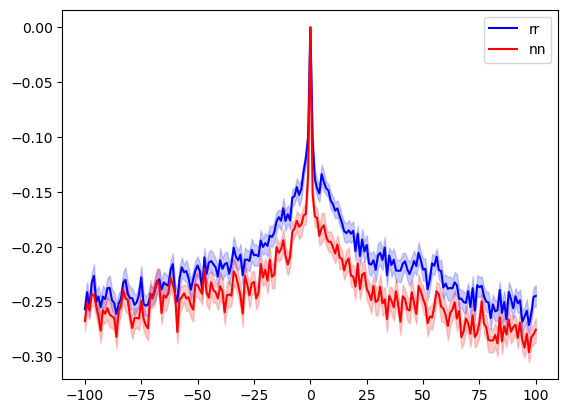

In [10]:
a = results_df.groupby(['relative_day','decoder']).mean()['relative_corr']
b = results_df.groupby(['relative_day','decoder']).sem()['relative_corr']
corr = pd.concat((a,b),axis=1,keys=['mean','sem']).groupby('decoder')

fig, ax = plt.subplots(1,1)
x = np.arange(len(corr))
for label in ('rr', 'nn'):
    color = 'b' if label == 'rr' else 'r'
    means = corr.get_group(label)['mean'].to_numpy()
    stds = corr.get_group(label)['sem'].to_numpy()
    x = np.arange(len(means)) - k

    ax.plot(x, means, f'{color}-', label=label)
    ax.fill_between(x, means - stds, means + stds, color=color, alpha=0.2)

plt.legend()

seems like correlatoin decreases by a good amount within 10 days, more for NN than RR.

seems to be exponential, log scale plot to check if first or second

seems to be first exponential, let's fit (one to either side)

[None]

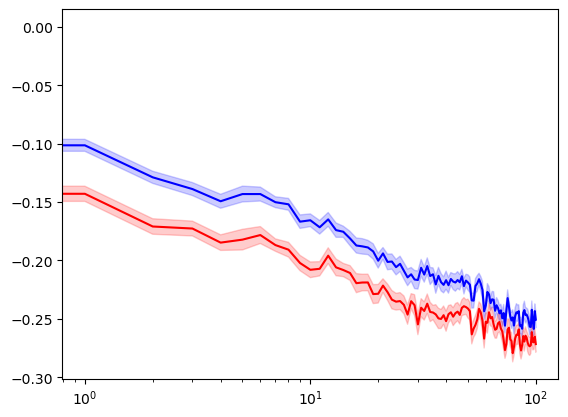

In [13]:
# get abs relative
results_df['absolute_relative_day'] = results_df['relative_day'].abs()

a = results_df.groupby(['absolute_relative_day','decoder']).mean()['relative_corr']
b = results_df.groupby(['absolute_relative_day','decoder']).sem()['relative_corr']
corr = pd.concat((a,b),axis=1,keys=['mean','sem']).groupby('decoder')

fig, ax = plt.subplots(1,1)
x = np.arange(k+1)
means_forexp = {}
for label in ('rr', 'nn'):
    color = 'b' if label == 'rr' else 'r'
    means = corr.get_group(label)['mean'].to_numpy()
    stds = corr.get_group(label)['sem'].to_numpy()

    ax.plot(x, means, f'{color}-', label=label)
    ax.fill_between(x, means - stds, means + stds, color=color, alpha=0.2)

    # fit exponential 
    means_forexp[label] = means

ax.set(xscale='log')
    

In [14]:
a.to_csv(os.path.join(source_folder,'short_term_means.csv'))

In [15]:
# fit exponential decay
nn_means = means_forexp['nn']
nn_offset = np.min(nn_means) - 0.0000001 #can't have divide by zero

rr_means = means_forexp['rr']
rr_offset = np.min(rr_means) - 0.0000001 #can't have divide by zero

days = x

def fit_exp_linear(t, y, C=0):
    y = y - C
    y = np.log(y)
    K, A_log = np.polyfit(t, y, 1)
    A = np.exp(A_log)
    return A, K

nn_A, nn_K = fit_exp_linear(days, nn_means, nn_offset)

rr_A, rr_K = fit_exp_linear(days, rr_means, rr_offset)

Text(0, 0.5, 'drop in correlation rel. to day 0')

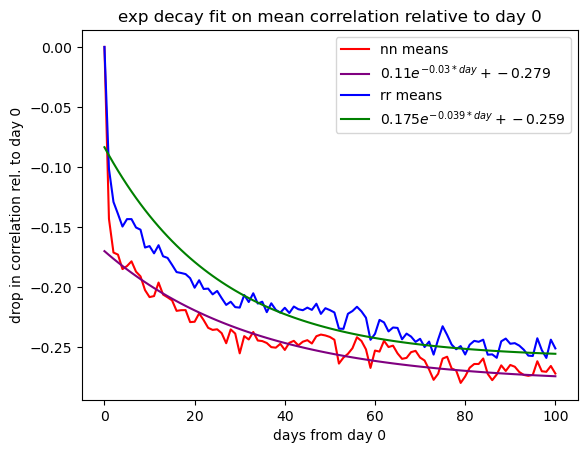

In [27]:
exp_decay_nn = nn_A * np.exp(nn_K * x) + nn_offset
exp_decay_rr = rr_A * np.exp(rr_K * x) + rr_offset

plt.plot(days, nn_means, label='nn means',color='r')
plt.plot(days, exp_decay_nn, label=f'${{{round(nn_A,3)}}}e^{{{round(nn_K,3)}*day}} + {round(nn_offset,3)}$',color='purple')
plt.plot(days, rr_means, label='rr means', color='b')
plt.plot(days, exp_decay_rr, label=f'${{{round(rr_A,3)}}}e^{{{round(rr_K,3)}*day}} + {round(rr_offset,3)}$',color='g')
plt.legend()
plt.title('exp decay fit on mean correlation relative to day 0')
plt.xlabel('days from day 0')
plt.ylabel('drop in correlation rel. to day 0')